In [1]:
import os
os.chdir("/home/jovyan")   
os.getcwd()

'/home/jovyan'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from numpy.linalg import norm

# 1. Загрузка очищенного датасета

In [3]:
df = pd.read_csv("data/airbnb_clean.csv")

print("Размер очищенного датасета:", df.shape)
print(df.head())

Размер очищенного датасета: (47635, 12)
   host_id neighbourhood_group neighbourhood  latitude  longitude  \
0     2787            Brooklyn    Kensington  40.64749  -73.97237   
1     2845           Manhattan       Midtown  40.75362  -73.98377   
2     4632           Manhattan        Harlem  40.80902  -73.94190   
3     4869            Brooklyn  Clinton Hill  40.68514  -73.95976   
4     7192           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews  \
0     Private room    149               1                  9   
1  Entire home/apt    225               1                 45   
2     Private room    150               3                  0   
3  Entire home/apt     89               1                  4   
4  Entire home/apt     80              10                  9   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               1               365  
1             

# 2. Выбор признаков для кластеризации

In [4]:
features = [
    "price",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
]

X = df[features].copy()

# На всякий случай выкинем оставшиеся NA
X = X.dropna()
print("Размер после удаления NA:", X.shape)

Размер после удаления NA: (47635, 6)


# 3. Масштабирование признаков

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features)

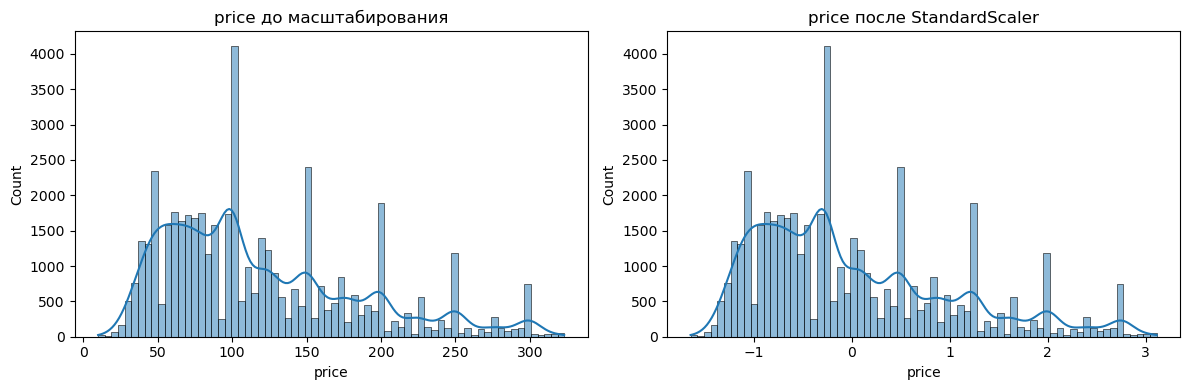

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df["price"], kde=True, ax=axes[0])
axes[0].set_title("price до масштабирования")

sns.histplot(X_scaled_df["price"], kde=True, ax=axes[1])
axes[1].set_title("price после StandardScaler")

plt.tight_layout()
plt.show()

# 4. PCA до 2 компонент (для визуализации кластеров)

In [7]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["pc1", "pc2"])
print("Доля объяснённой дисперсии PCA:", pca.explained_variance_ratio_)

Доля объяснённой дисперсии PCA: [0.25790337 0.18023525]


# 5. Собственная реализация K-means

In [22]:
def kmeans_custom(X, n_clusters, max_iter=100, random_state=42):
    """
    Простая реализация K-means.
    X: np.array shape (n_samples, n_features)
    """
    rng = np.random.default_rng(random_state)
    X = np.asarray(X)

    # случайный выбор стартовых центров
    indices = rng.choice(len(X), size=n_clusters, replace=False)
    centroids = X[indices]

    for _ in range(max_iter):
        # расстояния до центров
        dists = np.stack([norm(X - c, axis=1) for c in centroids], axis=1)
        labels = np.argmin(dists, axis=1)

        # пересчёт центров
        new_centroids = np.vstack([
            X[labels == k].mean(axis=0) if np.any(labels == k) else centroids[k]
            for k in range(n_clusters)
        ])

        # критерий останова
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return labels, centroids

In [9]:
labels_custom, centers_custom = kmeans_custom(X_pca, n_clusters=4)

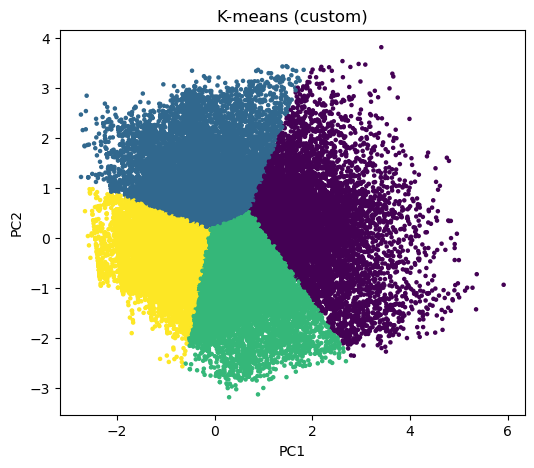

In [23]:
plt.figure(figsize=(6, 5))
plt.scatter(pca_df["pc1"], pca_df["pc2"], c=labels_custom, s=5)
plt.title("K-means (custom)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [24]:
sil_custom = silhouette_score(X_pca, labels_custom)
print(f"Silhouette KMeans custom: {sil_custom:.4f}")

Silhouette KMeans custom: 0.3513


# 6. KMeans из sklearn

In [11]:
km = KMeans(n_clusters=4, random_state=42)
labels_km = km.fit_predict(X_pca)

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


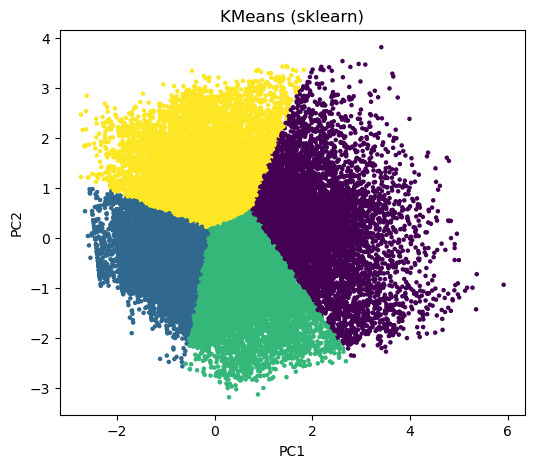

In [26]:
plt.figure(figsize=(6, 5))
plt.scatter(pca_df["pc1"], pca_df["pc2"], c=labels_km, s=5)
plt.title("KMeans (sklearn)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [27]:
sil_km = silhouette_score(X_pca, labels_km)
print(f"Silhouette KMeans sklearn: {sil_km:.4f}")

Silhouette KMeans sklearn: 0.3513


# 7. Agglomerative Clustering

In [13]:
n_sample = min(8000, X_pca.shape[0])
rng = np.random.RandomState(42)
idx_sub = rng.choice(X_pca.shape[0], size=n_sample, replace=False)

In [14]:
X_pca_sub = X_pca[idx_sub]

In [15]:
agg = AgglomerativeClustering(n_clusters=4)
labels_agg_sub = agg.fit_predict(X_pca_sub)

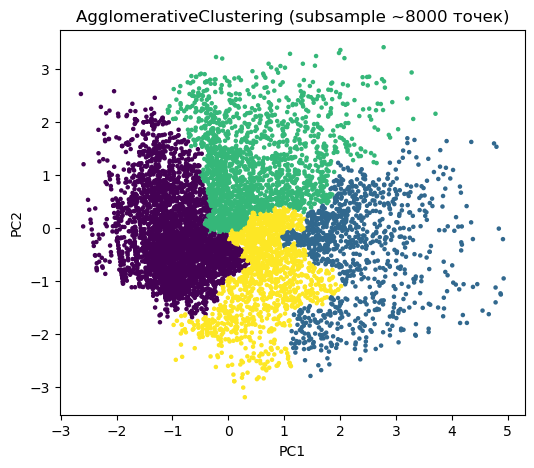

In [16]:
plt.figure(figsize=(6, 5))
plt.scatter(X_pca_sub[:, 0], X_pca_sub[:, 1], c=labels_agg_sub, s=5)
plt.title("AgglomerativeClustering (subsample ~8000 точек)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [17]:
sil_agg = silhouette_score(X_pca_sub, labels_agg_sub)
print(f"Silhouette Agglomerative (subsample): {sil_agg:.4f}")

Silhouette Agglomerative (subsample): 0.3018


# 8. Gaussian Mixture (GMM)

In [18]:
gm = GaussianMixture(n_components=4, random_state=42)
labels_gm = gm.fit_predict(X_pca)

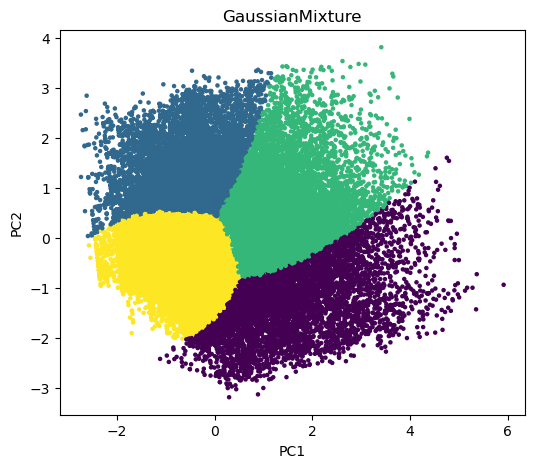

In [19]:
plt.figure(figsize=(6, 5))
plt.scatter(pca_df["pc1"], pca_df["pc2"], c=labels_gm, s=5)
plt.title("GaussianMixture")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [20]:
sil_gm = silhouette_score(X_pca, labels_gm)
print(f"Silhouette GaussianMixture: {sil_gm:.4f}")

Silhouette GaussianMixture: 0.3795


# 8. Silhouette scores

In [28]:
print("=== Silhouette scores ===")
print(f"KMeans custom              : {sil_custom:.4f}")
print(f"KMeans sklearn             : {sil_km:.4f}")
print(f"GaussianMixture (GMM)      : {sil_gm:.4f}")
print(f"Agglomerative (subsample)  : {sil_agg:.4f}")

=== Silhouette scores ===
KMeans custom              : 0.3513
KMeans sklearn             : 0.3513
GaussianMixture (GMM)      : 0.3795
Agglomerative (subsample)  : 0.3018


# 9. Интерпретация кластеров

In [29]:
# привязываем метки кластеров к исходным объектам
df_clusters = df.loc[X.index].copy()
df_clusters["cluster_km"] = labels_km

cluster_summary = df_clusters.groupby("cluster_km")[features].mean().round(2)
cluster_summary

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
cluster_km,,,,,,
0,112.94,2.09,25.09,2.20,1.46,201.07
1,93.34,3.01,2.83,0.16,1.06,27.98
2,77.43,2.13,9.49,0.85,1.62,137.88
3,202.76,2.84,6.73,0.57,1.04,148.10
